# OpenIFS 43r3 data

> [!NOTE]
> The online laboratory has only been tested in recent Firefox and Chrome browsers. Some features may not (yet) be supported in Safari browsers.

> [!CAUTION]
> Any changes you make to this notebook will be lost once the page is closed or refreshed. Please download any files you would like to keep.

This notebook is a comprehensive guide to accessing NetDCF files for an OpenIFS simulation. It includes details about the available parameters, levels, and steps, along with instructions for using the `load_netcdf_files` function to access these files from the [ECMWF S3 bucket](https://object-store.os-api.cci1.ecmwf.int/esiwacebucket/OpenIFS/). The NetCDF files are not downloaded locally; instead, they are accessed remotely using `kerchunk` and `zarr` via their corresponding `.ref` metadata files (also hosted in the S3 bucket), which were produced up-front using `kerchunk`.

---

## Experiment Details and Available Data Fields

The dataset contains uncompressed IEEE-754 Standard (1985) 64-bit floating-point output from the OpenIFS 43r3.
The simulation was conducted on a reduced Gaussian octahedral grid (Tco1279), corresponding to a horizontal resolution of approximately 9 km.
The 5-day forecast was run with a time step length of 600 seconds using a HighResMIP based output configuration.


There is a single NetCDF file for the surface level fields and separate files for each pressure level field.

### Pressure Level Parameters

The following parameters are available as pressure level fields:
```python
["z", "t", "q", "w", "vo", "d", "u", "v", "r"]
```

These parameters are stored at the following pressure levels (in Pa):
```python

[100000, 92500, 85000, 70000, 60000, 50000, 40000, 30000, 25000, 20000, 15000, 10000, 7000, 5000, 3000, 2000, 1000, 500, 100]

```
The available time steps start at 2009-10-15 18:00:00 UTC, increasing in 6-hour steps to 2009-10-20 12:00:00 UTC.

### Surface Level Parameters

The following parameters are available as surface level fields:
```python
["10u", "10v", "2d", "2t", "cp", "e", "es", "ewss", "msl", "nsss", "ro", "rsn", "sd", "sf", "skt", "slhf", "smlt", "sp", "sro", "sshf", "ssr", "ssrc", "ssrd", "stl1", "stl2", "stl3", "stl4", "str", "strc", "strd", "swvl1", "swvl2", "swvl3", "swvl4", "tcc", "tciw", "tclw", "tcwv", "tisr", "tp", "tsn", "tsr", "tsrc", "ttr", "ttrc"]
```

Here, the available time steps start at 2009-10-15 15:00:00 UTC, increasing in 3-hour steps to 2009-10-20 12:00:00 UTC.

## Using the `load_netcdf_files` Function

To load the NetCDF files, you can use the following function:

```python
load_netcdf_files(leveltype=None, gridtype=None, step=None, remap=False)
```

### Parameters

- **`leveltype`**: Defines the type of data to load. Choose one of the following:
  - `"pl"`: Pressure level fields.
  - `"sfc"`: Surface level fields.
  - `"wave"`: Wave model fields.
- **`param`**: Specifies the parameter of the pressure level data. Options include: `"z"`, `"t"`, `"q"`, `"w"`, `"vo"`, `"d"`, `"u"`, `"v"` and `"r"`.


In [68]:
# URL of S3 bucket
BASE_URL = "https://object-store.os-api.cci1.ecmwf.int/esiwacebucket"

First, the package `zarr` (modern dataset format that is specifically designed for chunked access), its dependencies, and `gribscan` need to be imported for the remote access.

In [69]:
import aiohttp
import fsspec
import gribscan
import zarr

The `load_netcdf_files` function simplifies remote access to GRIB datasets stored on the S3 bucket. It validates input parameters, constructs the correct URL for the requested data, and loads it efficiently as an xarray dataset using the corresponding `.ref` file.


In [70]:
import json

import requests
import xarray as xr


def load_netcdf_files(leveltype=None, param=None):
    if leveltype not in {"pl", "sfc"}:
        raise ValueError(f"Invalid leveltype: {leveltype}")

    if leveltype == "pl" and not param:
        raise ValueError(f"Param is required for leveltype '{leveltype}'. Available params: q, r, t, u, v, vo, w, z")

    if leveltype == "sfc" and param:
        print("Warning: Specifying 'param' is unnecessary for sfc level and will be ignored.")

    if leveltype == "sfc":
        url = f"{BASE_URL}/OpenIFS/HighResMIP_3h_reduced_sfc.nc"
    elif leveltype == "pl":
        if param not in {"q", "r", "t", "u", "v", "vo", "w", "z"}:
            raise ValueError(f"Incorrect param: '{param}'. Available: q, r, t, u, v, vo, w, z")

        url = f"{BASE_URL}/OpenIFS/HighResMIP_6h_reduced_pl_{param}.nc"
        
    ref = requests.get(f"{url}.ref").json()

    print(f"Loading dataset {url}")

    return xr.open_dataset(
        "reference://", 
        engine="zarr", 
        backend_kwargs={"storage_options": {"fo": ref}},
        consolidated=False, 
        chunks=dict(),
    )

## Example Usage

To load NetCDF file for pressure level parameters, you can use the following example. This will load the **specific humidity (q)** data. 


In [71]:
ds_pl_q = load_netcdf_files(leveltype="pl", param="q")
ds_pl_q

Loading dataset https://object-store.os-api.cci1.ecmwf.int/esiwacebucket/OpenIFS/HighResMIP_6h_reduced_pl_q.nc


<xarray.Dataset>
Dimensions:              (cell: 6599680, nvertex: 4, pressure_levels: 19,
                          time_counter: 20, axis_nbounds: 2)
Coordinates:
    lat                  (cell) float32 dask.array<chunksize=(824960,), meta=np.ndarray>
    lon                  (cell) float32 dask.array<chunksize=(824960,), meta=np.ndarray>
  * pressure_levels      (pressure_levels) float32 1e+05 9.25e+04 ... 100.0
  * time_counter         (time_counter) datetime64[ns] 2009-10-15T18:00:00 .....
    time_instant         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables:
    bounds_lat           (cell, nvertex) float32 dask.array<chunksize=(206240, 4), meta=np.ndarray>
    bounds_lon           (cell, nvertex) float32 dask.array<chunksize=(206240, 4), meta=np.ndarray>
    q                    (time_counter, pressure_levels, cell) float64 dask.array<chunksize=(1, 1, 412480), meta=np.ndarray>
    time_counter_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_instant_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    description:  Created by xios
    name:         HighResMIP_6h_reduced_pl_q
    timeStamp:    2024-Apr-05 11:05:21 GMT
    title:        Created by xios
    uuid:         25d5f0a2-ceae-47e1-936f-5b1804228ca6

The `earthkit` package is used for plotting the data.

In [72]:
import earthkit.plots
import earthkit.plots.quickmap

The data can be visualized as demonstrated below. For example, the specific humidity at **pressure level 10e5** on **2009-10-20 at 12:00:00 UTC** is plotted. `[::10]` applies slicing to the data being plotted (syntax: `[start:stop:step]`) in order to reduce computational load by selecting only every 10th data point.


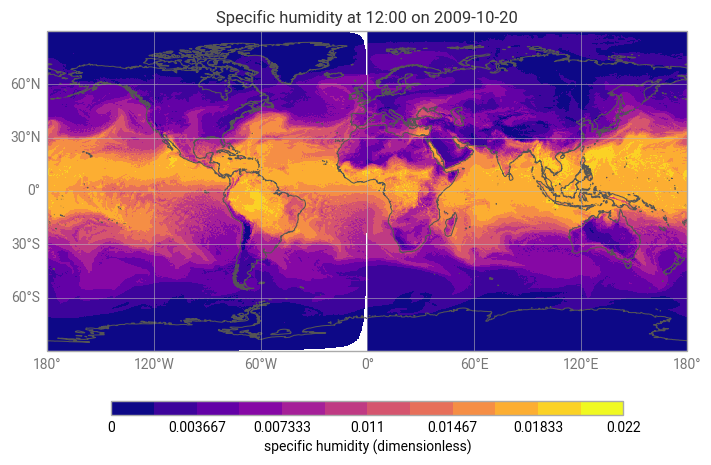

In [73]:
earthkit.plots.quickmap.plot(
    ds_pl_q["q"].rename(dict(time_counter="time")).sel(
        time="2009-10-20T12:00:00", pressure_levels=1e5,
    )[::10], x="lon", y="lat",
);

The surface level data contains all available parameters and can can be loaded as follows.

In [75]:
ds_sfc = load_netcdf_files(leveltype="sfc")
ds_sfc

Loading dataset https://object-store.os-api.cci1.ecmwf.int/esiwacebucket/OpenIFS/HighResMIP_3h_reduced_sfc.nc


<xarray.Dataset>
Dimensions:              (time_counter: 40, cell: 6599680, nvertex: 4,
                          axis_nbounds: 2)
Coordinates:
    lat                  (cell) float32 dask.array<chunksize=(824960,), meta=np.ndarray>
    lon                  (cell) float32 dask.array<chunksize=(824960,), meta=np.ndarray>
  * time_counter         (time_counter) datetime64[ns] 2009-10-15T15:00:00 .....
    time_instant         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/49)
    10u                  (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
    10v                  (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
    2d                   (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
    2t                   (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
    bounds_lat           (cell, nvertex) float32 dask.array<chunksize=(206240, 4), meta=np.ndarray>
    bounds_lon           (cell, nvertex) float32 dask.array<chunksize=(206240, 4), meta=np.ndarray>
    ...                   ...
    tp                   (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
    tsn                  (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
    tsr                  (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
    tsrc                 (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
    ttr                  (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
    ttrc                 (time_counter, cell) float64 dask.array<chunksize=(1, 412480), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    description:  Created by xios
    name:         HighResMIP_3h_reduced_sfc
    timeStamp:    2024-Apr-05 10:55:20 GMT
    title:        Created by xios
    uuid:         dbac5691-165e-4465-bd75-e403aa400071

The data can be visualized as demonstrated below. For example, the 2 metre temperature on **2009-10-20 at 12:00:00 UTC** is plotted.

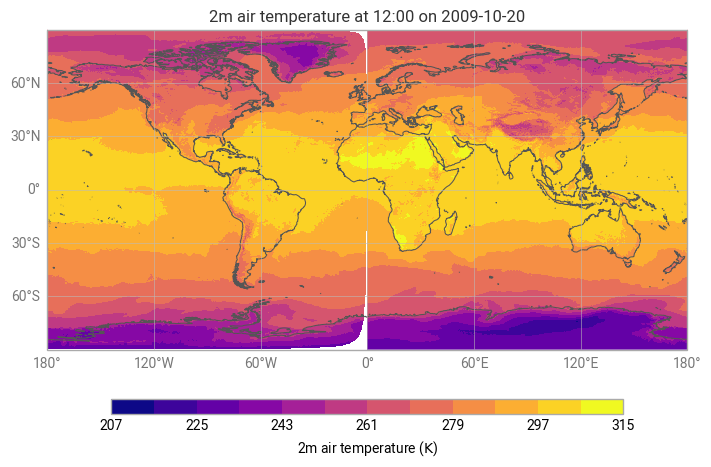

In [76]:
earthkit.plots.quickmap.plot(
    ds_sfc["2t"].rename(dict(time_counter="time")).sel(
        time="2009-10-20T12:00:00",
    )[::10], x="lon", y="lat",
);
